In [1]:
import numpy as np
import pandas as pd
from typing import Dict, Tuple
from scipy import stats
from IPython.display import Image
from io import StringIO 
from IPython.display import Image
import graphviz 
import pydotplus
from sklearn.datasets import load_iris, load_boston
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

In [2]:
def vis_models_quality(array_metric, array_labels, str_header, figsize=(5, 5)):
    fig, ax1 = plt.subplots(figsize=figsize)
    pos = np.arange(len(array_metric))
    rects = ax1.barh(pos, array_metric,
                     align='center',
                     height=0.5, 
                     tick_label=array_labels)
    ax1.set_title(str_header)
    for a,b in zip(pos, array_metric):
        plt.text(0.2, a-0.1, str(round(b,3)), color='white')
    plt.show()

# [Стекинг и блендинг](https://en.wikipedia.org/wiki/Ensemble_learning#Stacking)

Термины "стекинг" и "блендинг" иногда используют как синонимы (что не совсем корректно). Блендинг можно считать упрощенным вариантом стекинга.

## Краткое описание метода

Во всех ансамблевых моделях явно или неявно используется модель верхнего уровня. В стекинге для такой модели используется явное название **мета-ученик (meta-learner)** или **модель 2 уровня (level 2 model)**.

В моделях на основе бэггинга (бэггинг, случайный лес, сверхслучайные деревья) в качестве модели 2 уровня используется усреднение результатов голосования моделей.

В моделях на основе бустинга используется взвешенная сумма результатов голосования моделей. Бустинг может рассматриваться как разновидность линейной регресии, где регрессорами являются выходы "слабых моделей".

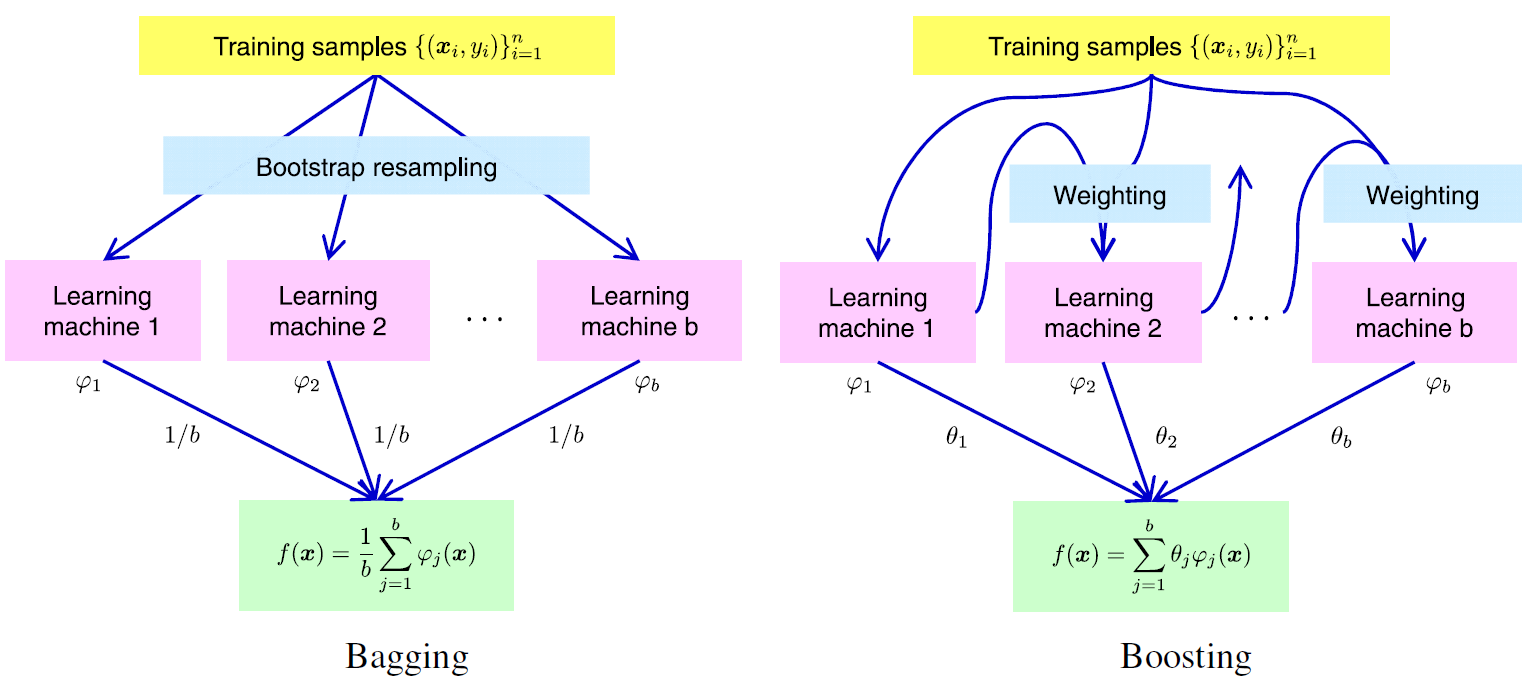

In [3]:
Image('img/boosting.png', width='70%')

Стекинг принципиальноо отличается от моделей на основе бэггинга и бустинга следующим:
1. Мета-ученик является отдельной моделью машинного обучения, 
выходы "слабых моделей" рассматриваются как входные признаки 
для мета-ученика.

1. В качестве "слабых моделей" рассматриваются различные модели, которые дают различные результаты. (Напомним, что в бэггинге использовались различные выборки, но одинаковая модель). Эти результаты рассматриваются как входные признаки для мета-ученика. 

Идея стекинга показана на следующем рисунке:

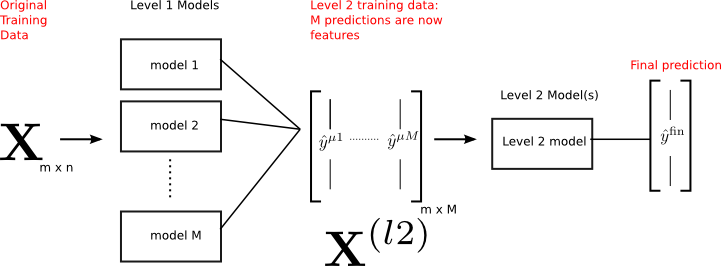

In [4]:
#Источник - https://www.kdnuggets.com/2017/02/stacking-models-imropved-predictions.html
Image('img/stacking.png', width='70%')

Модели 1 уровня обычно сложные и использующие различные алгоритмы, например SVM, дерево решений, случайный лес и т.д. Использование различных алгоритмов, фактически, обеспечивает дисперсию внутри модели, а также исключает возможность возникновения линейной зависимости между признаками, поступающими на вход модели 2 уровня.

Модели 2 уровня обычно простые. Часто используются линейные модели. Например для задачи регрессии - линейная регрессия, для задачи классификации - логистическая регрессия. 

Концепции стекинга и блендинга очень детально рассмотрены в [блоге профессора Александра Геннадьевича Дьяконова.](https://dyakonov.org/2017/03/10/c%d1%82%d0%b5%d0%ba%d0%b8%d0%bd%d0%b3-stacking-%d0%b8-%d0%b1%d0%bb%d0%b5%d0%bd%d0%b4%d0%b8%d0%bd%d0%b3-blending/)

## Эксперименты

В scikit-learn данная модель не реализована напрямую. Она реализована в библиотеке [heamy.](https://heamy.readthedocs.io/en/latest/)

In [5]:
from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline
from heamy.dataset import Dataset

In [6]:
boston = load_boston()
boston_X, boston_y = boston['data'], boston['target']
boston_X_train, boston_X_test, boston_y_train, boston_y_test = train_test_split(
    boston_X, boston_y, test_size=0.2, random_state=1)

In [7]:
# Качество отдельных моделей
def val_mae(model):
    model.fit(boston_X_train, boston_y_train)
    y_pred = model.predict(boston_X_test)
    result = mean_absolute_error(boston_y_test, y_pred)
    print(model)
    print('MAE={}'.format(result))

In [8]:
# Точность на отдельных моделях
for model in [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(n_estimators=50)
]:
    val_mae(model)
    print('==========================')
    print()

LinearRegression()
MAE=3.7507121808389168

DecisionTreeRegressor()
MAE=3.327450980392157

RandomForestRegressor(n_estimators=50)
MAE=2.2932156862745097



In [9]:
# Используем библиотеку heamy
# набор данных
dataset = Dataset(boston_X_train, boston_y_train, boston_X_test)

# модели первого уровня
model_tree = Regressor(dataset=dataset, estimator=DecisionTreeRegressor, name='tree')
model_lr = Regressor(dataset=dataset, estimator=LinearRegression, parameters={'normalize': True},name='lr')
model_rf = Regressor(dataset=dataset, estimator=RandomForestRegressor, parameters={'n_estimators': 50},name='rf')

In [10]:
# Эксперимент 1
# Первый уровень - две модели: дерево и линейная регрессия
# Второй уровень: линейная регрессия

pipeline = ModelsPipeline(model_tree, model_lr)
stack_ds = pipeline.stack(k=10, seed=1)
# модель второго уровня
stacker = Regressor(dataset=stack_ds, estimator=LinearRegression)
results = stacker.validate(k=10,scorer=mean_absolute_error)

Metric: mean_absolute_error
Folds accuracy: [2.2732855390954505, 2.4057163991038144, 2.3940028938918596, 3.062465604660772, 2.9473463485924056, 2.653565368240077, 2.657112334558009, 2.53683179257099, 2.6427782276499685, 3.193399523560955]
Mean accuracy: 2.6766504031924305
Standard Deviation: 0.2875358418931061
Variance: 0.0826768603731773


In [11]:
# Эксперимент 2
# Первый уровень - две модели: дерево и линейная регрессия
# Второй уровень: случайный лес

stacker = Regressor(dataset=stack_ds, estimator=RandomForestRegressor)
results = stacker.validate(k=10,scorer=mean_absolute_error)

Metric: mean_absolute_error
Folds accuracy: [2.5358536585365874, 2.449829268292681, 2.3774146341463376, 3.455951219512197, 2.807325000000003, 2.7213500000000024, 2.084374999999997, 2.8247749999999985, 2.4680000000000013, 3.050600000000002]
Mean accuracy: 2.6775473780487804
Standard Deviation: 0.36650969400738626
Variance: 0.13432935580138788


In [12]:
# Эксперимент 3
# Первый уровень - три модели: дерево, линейная регрессия и случайный лес
# Второй уровень: линейная регрессия
pipeline = ModelsPipeline(model_tree, model_lr, model_rf)
stack_ds3 = pipeline.stack(k=10, seed=1)
# модель второго уровня
stacker = Regressor(dataset=stack_ds3, estimator=LinearRegression)
results = stacker.validate(k=10,scorer=mean_absolute_error)

Metric: mean_absolute_error
Folds accuracy: [1.81855120406732, 2.149094933334621, 2.0151300509276426, 3.2138360582103065, 2.5049742859274717, 2.1300134344739385, 2.433971337542571, 2.3853333560377914, 2.1541958928407263, 2.1932855893484366]
Mean accuracy: 2.2998386142710823
Standard Deviation: 0.3604995208538116
Variance: 0.12995990453582776


In [13]:
# Эксперимент 4
# Первый уровень - три модели: дерево, линейная регрессия и случайный лес
# Второй уровень: случайный лес
# Результат хуже чем в эксперименте 3
stacker = Regressor(dataset=stack_ds3, estimator=RandomForestRegressor)
results = stacker.validate(k=10,scorer=mean_absolute_error)

Metric: mean_absolute_error
Folds accuracy: [2.0469999999999984, 2.541073170731706, 2.0407317073170685, 3.025024390243902, 2.49895, 2.498125000000002, 2.656575, 2.2167750000000015, 2.111374999999999, 2.4294750000000014]
Mean accuracy: 2.406510426829268
Standard Deviation: 0.29441652349645325
Variance: 0.08668108930773762


In [14]:
# Результаты
array_labels = ['LR','TREE', 'RF', 'TREE+LR=>LR', 
                'TREE+LR=>RF', 'TREE+LR+RF=>LR', 'TREE+LR+RF=>RF']
array_mae = [3.7507121808389168, 2.942156862745098, 2.263039215686275, 
             2.6766504031924305, 2.6775473780487804, 2.2998386142710823, 
             2.406510426829268]

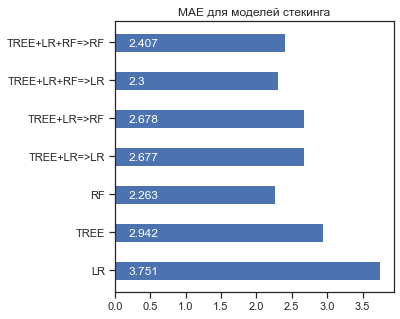

In [15]:
# Визуализация результатов
vis_models_quality(array_mae, array_labels, 'MAE для моделей стекинга')

Вывод: лучший результат стекинга сравним с наиболее сильной моделью 1 уровня (случайным лесом).

В сообществе анализа данных существует афоризм, что "стекинг - не технология серебряной пули, а технология последней мили".

За счет того, что модель стекинга слабо поддается интерпертации, в основном эта модель используется тогда, когда нужно улучшить качество модели на конкретном наборе данных. Например, в соревнованиях по анализу данных.

## Дополнительные источники
- [Блог Александра Дьяконова. Cтекинг (Stacking) и блендинг (Blending)](https://dyakonov.org/2017/03/10/c%d1%82%d0%b5%d0%ba%d0%b8%d0%bd%d0%b3-stacking-%d0%b8-%d0%b1%d0%bb%d0%b5%d0%bd%d0%b4%d0%b8%d0%bd%d0%b3-blending/)
- https://neurohive.io/ru/osnovy-data-science/ansamblevye-metody-begging-busting-i-steking/
- https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/